<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter16/Conditional_Diffuser_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install -q diffusers torch-snippets

In [ ]:
from torch_snippets import *
from diffusers import DDPMScheduler, UNet2DModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(32),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=transform)

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [3]:
class EmbeddingLayer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, labels):
        return self.embedding(labels)

embedding_layer = EmbeddingLayer(num_embeddings=10, embedding_dim=32).to(device)

class ConditionalUNet2DModel(UNet2DModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels += 32  # Adjust for embedding dimension

net = ConditionalUNet2DModel(
    sample_size=28,
    in_channels=1 + 32,  # 1 for original channel, 20 for embedding
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(32, 64, 128, 256),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
).to(device)

<ipython-input-3-b4d2261193b8>:14: FutureWarning: Accessing config attribute `in_channels` directly via 'ConditionalUNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'ConditionalUNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  self.in_channels += 32  # Adjust for embedding dimension


In [4]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

def corrupt_with_embedded_labels(xb, labels, timesteps=None):
    if timesteps is None:
        timesteps = torch.randint(0, 999, (len(xb),)).long().to(device)
    noise = torch.randn_like(xb)
    noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
    labels_embedded = embedding_layer(labels).unsqueeze(-1).unsqueeze(-1)
    labels_embedded = labels_embedded.expand(-1, -1, xb.shape[2], xb.shape[3])
    return torch.cat([noisy_xb, labels_embedded], dim=1), timesteps

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=len(train_dataloader), verbose=False)

n_epochs = 3
report = Report(n_epochs)

In [5]:
for epoch in range(n_epochs):
    n = len(train_dataloader)
    for bx, (x, labels) in enumerate(train_dataloader):
        x = x.to(device)
        labels = labels.to(device)
        noisy_x, timesteps = corrupt_with_embedded_labels(x, labels)
        pred = net(noisy_x, timesteps).sample # Exclude the embedding channels from the prediction
        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
        report.record(epoch + ((bx + 1) / n), loss=loss.item(), end='\r')
    report.report_avgs(epoch + 1)

EPOCH: 1.000  loss: 0.037  (125.10s - 250.19s remaining)
EPOCH: 2.000  loss: 0.032  (247.29s - 123.65s remaining)
EPOCH: 3.000  loss: 0.030  (368.81s - 0.00s remaining)


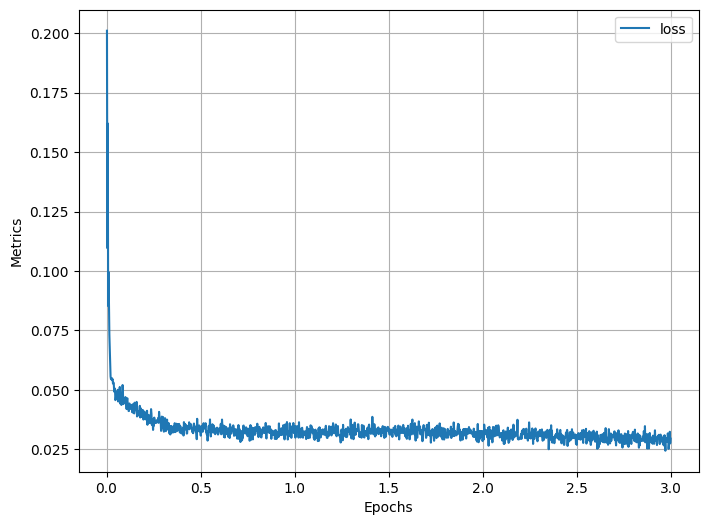

In [6]:
report.plot()

In [7]:
x.shape

torch.Size([96, 1, 32, 32])

In [8]:
xb = torch.zeros(10, 1, 32, 32)

In [9]:
timesteps = torch.randint(999, 1000, (len(xb),)).long().to(device)

In [10]:
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps).to(device)

In [11]:
labels = torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device)  # Labels for which you want to generate images

In [12]:
labels_embedded = embedding_layer(labels).unsqueeze(-1).unsqueeze(-1)
labels_embedded = labels_embedded.expand(-1, -1, xb.shape[2], xb.shape[3]).to(device)

In [13]:
noisy_x = torch.cat([noisy_xb, labels_embedded], dim=1)

In [14]:
pred = net(noisy_x, timesteps).sample.permute(0,2,3,1).reshape(-1, 32, 32)

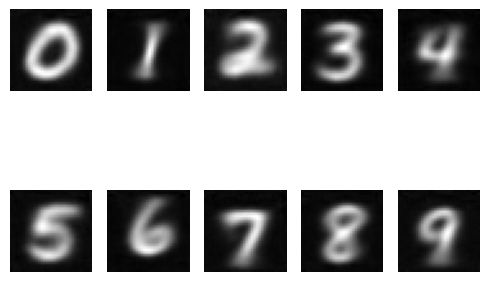

In [15]:
subplots(pred.detach().cpu().numpy())

101

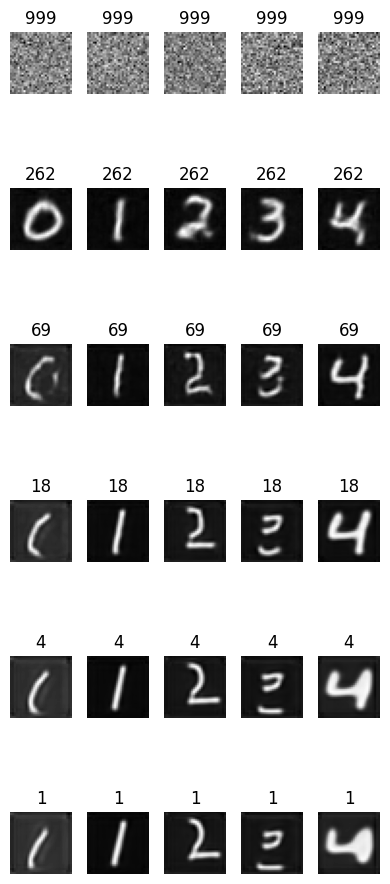

<Figure size 640x480 with 0 Axes>

In [16]:
device = 'cuda'
net.to(device)
# device = 'cpu'
labels = torch.Tensor([0, 1, 2, 3, 4]).long().to(device)  # Labels for which you want to generate images
embeddings = embedding_layer(labels)  # Generate embeddings for each label
embeddings = embeddings.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 32, 32)  # Resize to match the spatial dimensions of the noise

noise = torch.randn(labels.size(0), 1, 32, 32).to(device)  # Generate initial noise
progress = [noise]

for ts in np.logspace(np.log10(999), 0.1, 100):
    ts_tensor = torch.Tensor([ts]).long().expand(labels.size(0)).to(device)
    if ts>998:
      combined_input = torch.cat([noise, embeddings], dim=1)  # Combine noise and label embeddings
    else:
      combined_input = noise
    noise = net(combined_input, ts_tensor).sample.detach()  # Generate image conditioned on label
    #noise = noise[:, :-20, :, :]  # Exclude the embedding channels from the output
    progress.append(noise)
    # Recorrupt the noise for the next step
    noise, _ = corrupt_with_embedded_labels(noise, labels, ts_tensor)

print(len(progress))
_n = 20
subplots(
    torch.cat(progress, dim=1)[:,::_n].permute(1, 0, 2, 3).reshape(-1, 32, 32),
    nc=5,
    sz=(4, 10),
    titles=flatten([[int(i)]*len(labels) for i in np.logspace(np.log10(999), 0.1, 101)[::_n]])
)
plt.tight_layout()
